In [532]:
import torch
print("Torch version:", torch.__version__)


Torch version: 2.9.1+cpu


In [533]:
import torch.nn as nn

## Reproducibility

We fix random seeds so training results are reproducible.

In [534]:
import random
import torch

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

## Defining a Custom PyTorch Layer

Here we define a new layer called `LearnedAffine`.

- This layer will become part of a neural network.
- It inherits from `nn.Module`, which is the base class for all PyTorch layers and models.
- The purpose of this layer is to apply a simple, learnable transformation to the input:
  
      output = input * gamma + beta

where `gamma` and `beta` are learnable parameters.

This definition does **not run any data yet** — it only tells PyTorch what the layer *is* and how it behaves when it receives input.


In [535]:
class LearnedAffine(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))
    def forward(self, x):
        return x * self.gamma + self.beta

## Creating an Instance of the Layer

Now we create an actual instance of the `LearnedAffine` layer.

- `dim` specifies how many features (columns) the input will have.
- This determines the length of `gamma` and `beta`.
- At this point, `gamma` is initialized to all 1s and `beta` to all 0s.

This step creates the layer object, but it still has not processed any data yet.

In [536]:
layer = LearnedAffine(dim=4)
print(layer)

LearnedAffine()


## Inspecting the Layer's Parameters

Here we inspect the internal learnable parameters of the layer.

- `named_parameters()` returns all trainable values inside the layer.
- We print their names, shapes, and current values.
- This lets us verify that:
  - `gamma` and `beta` exist
  - They have the correct shape
  - They are marked as trainable (`requires_grad=True`)

This is a sanity check to make sure the layer is set up correctly before using it.

In [537]:
for name, param in layer.named_parameters():
    print(name, param.shape, param)

gamma torch.Size([4]) Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)
beta torch.Size([4]) Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True)


## Creating Example Input Data

Here we create a small example input tensor `x`.

- Each row represents one input example.
- Each column represents one feature.
- In this toy example, the numbers are just chosen so we can easily see what happens.

This is not real image data — it is just a simple stand-in to help us understand how the layer transforms values.


In [538]:
x = torch.tensor([
    [1.0, 2.0, 3.0, 4.0],
    [10.0, 20.0, 30.0, 40.0]
])

y = layer(x)
print("Input x:\n", x)
print("Output y:\n", y)


Input x:
 tensor([[ 1.,  2.,  3.,  4.],
        [10., 20., 30., 40.]])
Output y:
 tensor([[ 1.,  2.,  3.,  4.],
        [10., 20., 30., 40.]], grad_fn=<AddBackward0>)


## Manually Adjusting Parameters to See Their Effect

Here we manually change the values of `gamma` and `beta` so we can clearly see how they affect the output.

- `torch.no_grad()` temporarily disables gradient tracking.
- This lets us overwrite parameter values without interfering with training.
- We choose values that make the transformation visually obvious.

This is only for exploration and understanding — not something we would do during real training.


In [539]:
with torch.no_grad():
    layer.gamma[:] = torch.tensor([2.0, 0.5, -1.0, 10.0])
    layer.beta[:] = torch.tensor([1.0, 1.0, 1.0, 1.0])

y2 = layer(x)
print("New gamma:", layer.gamma)
print("New beta:", layer.beta)
print("New output y2:\n", y2)


New gamma: Parameter containing:
tensor([ 2.0000,  0.5000, -1.0000, 10.0000], requires_grad=True)
New beta: Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)
New output y2:
 tensor([[  3.,   2.,  -2.,  41.],
        [ 21.,  11., -29., 401.]], grad_fn=<AddBackward0>)


## Visualizing the Transformation as a Table

Here we organize the input, parameters, and output into a table.

- This helps us visually connect each input value to its corresponding `gamma`, `beta`, and output.
- Each row in the table corresponds to one feature (column in the original input).
- This makes it easier to see how the transformation is applied element by element.

This view is meant to replace mental math with something we can directly see.


In [540]:
import pandas as pd

df = pd.DataFrame({
    "x_row1": x[0].tolist(),
    "gamma": layer.gamma.tolist(),
    "beta": layer.beta.tolist(),
    "y_row1": y2[0].tolist()
})

df


,x_row1,gamma,beta,y_row1
0,1.0,2.0,1.0,3.0
1,2.0,0.5,1.0,2.0
2,3.0,-1.0,1.0,-2.0
3,4.0,10.0,1.0,41.0


# Part 2 — Load FashionMNIST (see the real inputs)

Now we’ll load the FashionMNIST dataset.

What we want to learn here:
- What one image looks like (shape)
- What a batch looks like (rows = images in the batch)
- What the labels look like (the correct class for each image)

We will NOT train yet — just load + inspect.


In [541]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


## Preparing the image data

Images are loaded as PIL images by default.  
We convert them to tensors and normalize them so the values are in a reasonable numeric range for training.


In [542]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


## Loading FashionMNIST

We download the dataset and create training and test splits.

In [543]:
train_ds = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
test_ds  = datasets.FashionMNIST(root="data", train=False, download=True, transform=transform)


## Creating DataLoaders

A DataLoader groups examples into batches so we can process many images at once.

In [544]:
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)

## Inspecting a batch

Let’s look at the shape of one batch to see how the data is structured.

In [545]:
images, labels = next(iter(train_loader))
print("images shape:", images.shape)
print("labels shape:", labels.shape)
print("labels:", labels)

images shape: torch.Size([4, 1, 28, 28])
labels shape: torch.Size([4])
labels: tensor([5, 7, 4, 7])


| Number | Meaning                             |
| ------ | ----------------------------------- |
| 4      | 4 images in this batch → **4 rows** |
| 1      | 1 color channel (grayscale)         |
| 28     | height of image                     |
| 28     | width of image                      |


## Visualizing an image

Let’s look at one image from the batch to see what the network is actually receiving.


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

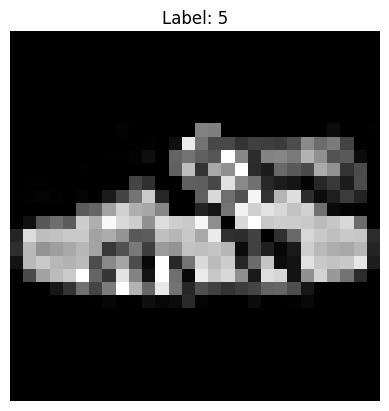

In [546]:
import matplotlib.pyplot as plt

plt.imshow(images[0][0], cmap="gray")
plt.title(f"Label: {labels[0].item()}")
plt.axis("off")


## Flattening images

Neural network layers usually expect 2D input:

- Rows = examples
- Columns = features

So we flatten each 28×28 image into a vector of length 784.


In [547]:
flat_images = images.view(images.shape[0], -1)
print("flat_images shape:", flat_images.shape)


flat_images shape: torch.Size([4, 784])


## Applying the custom layer to real data

Now we apply our `LearnedAffine` layer to flattened image data to see what it does.


In [548]:
real_layer = LearnedAffine(dim=784)
out = real_layer(flat_images)

print("Output shape:", out.shape)

Output shape: torch.Size([4, 784])


## Building a simple classifier model

We will build a small model that outputs 10 class scores (logits).

Pipeline:
1. Flatten image (784 features)
2. Custom layer: LearnedAffine(784)
3. Linear layer: 784 → 10 classes

The output will have shape: (batch_size, 10)


In [549]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.affine = LearnedAffine(784)
        self.fc = nn.Linear(784, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)   # flatten
        x = self.affine(x)           # custom layer
        x = self.fc(x)               # class scores
        return x


In [550]:
model = SimpleNet()
logits = model(images)
print("logits shape:", logits.shape)


logits shape: torch.Size([4, 10])


## Training setup

We define:
- A loss function to measure how wrong predictions are.
- An optimizer to adjust the model parameters.


In [551]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

## One training step

A single training step consists of:
1. Make predictions
2. Compute loss
3. Backpropagate gradients
4. Update parameters


In [552]:
model.train()

optimizer.zero_grad()
preds = model(images)
loss = loss_fn(preds, labels)
loss.backward()
optimizer.step()

print("Loss after one step:", loss.item())

Loss after one step: 2.337160110473633


## DataLoaders for training and evaluation

We use:
- a shuffled training loader
- a non-shuffled test loader

Batch size can be larger for training (faster + more stable gradients).


In [553]:
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)


## Learning rate scheduler (StepLR)

A scheduler changes the learning rate over time.
StepLR reduces the learning rate by a factor (`gamma`) every `step_size` epochs.

This can help training stabilize as we get closer to a good solution.


In [554]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
print("Current LR:", optimizer.param_groups[0]["lr"])


Current LR: 0.001


## Training for one epoch

This function:
- Puts the model in training mode
- Loops over all training batches
- Updates model parameters
- Tracks average loss and accuracy

In [555]:
def train_one_epoch(model, loader, loss_fn, optimizer):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    for x, y in loader:
        optimizer.zero_grad()
        preds = model(x)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (preds.argmax(dim=1) == y).sum().item()
        total_examples += x.size(0)

    avg_loss = total_loss / total_examples
    avg_acc = total_correct / total_examples
    return avg_loss, avg_acc

## Evaluating (no training)

During evaluation:
- We switch to eval mode (`model.eval()`)
- We turn off gradient tracking (`torch.no_grad()`)

This makes evaluation faster and ensures we don't accidentally update the model.

In [556]:
def eval_one_epoch(model, loader, loss_fn):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    with torch.no_grad():
        for x, y in loader:
            preds = model(x)
            loss = loss_fn(preds, y)

            total_loss += loss.item() * x.size(0)
            total_correct += (preds.argmax(dim=1) == y).sum().item()
            total_examples += x.size(0)

    avg_loss = total_loss / total_examples
    avg_acc = total_correct / total_examples
    return avg_loss, avg_acc

## Running training for 3 epochs

Each epoch:
1. Trains on all training data
2. Evaluates on test data
3. Steps the scheduler
4. Prints metrics


In [557]:
epochs = 3

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, loss_fn, optimizer)
    val_loss, val_acc = eval_one_epoch(model, test_loader, loss_fn)

    scheduler.step()

    lr = optimizer.param_groups[0]["lr"]
    print(
        f"Epoch {epoch}/{epochs} | "
        f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
        f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f} | "
        f"LR: {lr:.6f}"
    )

Epoch 1/3 | Train loss: 0.6198, acc: 0.7879 | Val loss: 0.5152, acc: 0.8200 | LR: 0.000900
Epoch 2/3 | Train loss: 0.4664, acc: 0.8375 | Val loss: 0.4910, acc: 0.8225 | LR: 0.000810
Epoch 3/3 | Train loss: 0.4409, acc: 0.8474 | Val loss: 0.4826, acc: 0.8287 | LR: 0.000729


## Training Results: Loss + Accuracy over Epochs

These plots show how the model improved across 3 epochs:
- Loss should generally go down
- Accuracy should generally go up


In [558]:
import torch
print("Torch version:", torch.__version__)


Torch version: 2.9.1+cpu


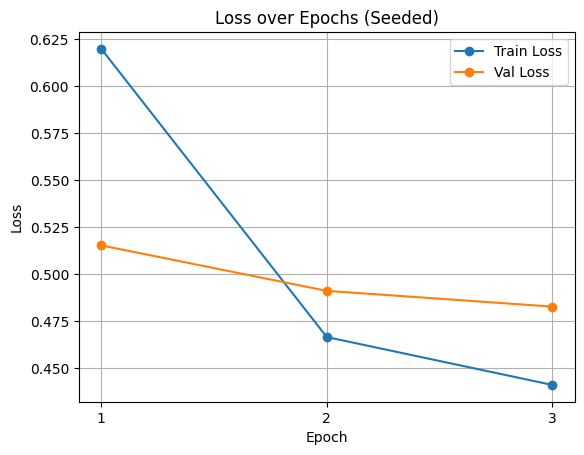

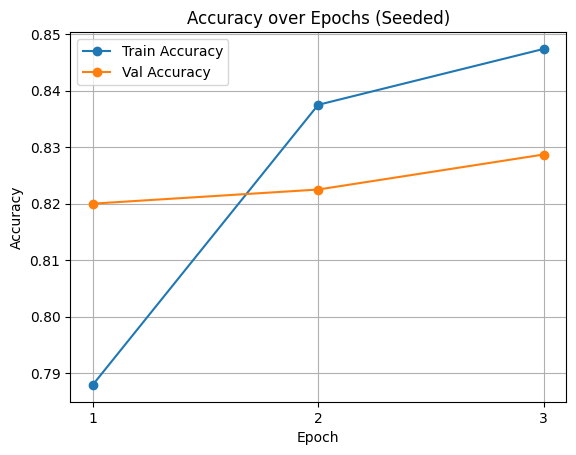

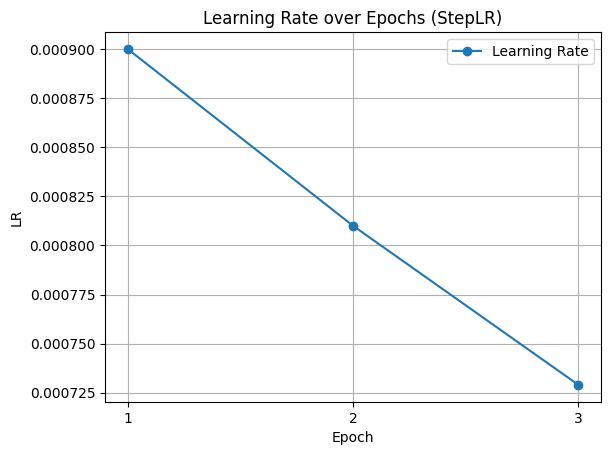

In [559]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3]

train_loss = [0.6198, 0.4664, 0.4409]
val_loss   = [0.5152, 0.4910, 0.4826]

train_acc = [0.7879, 0.8375, 0.8474]
val_acc   = [0.8200, 0.8225, 0.8287]

lrs = [0.000900, 0.000810, 0.000729]

# Loss plot
plt.figure()
plt.plot(epochs, train_loss, marker="o", label="Train Loss")
plt.plot(epochs, val_loss, marker="o", label="Val Loss")
plt.xticks(epochs)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs (Seeded)")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy plot
plt.figure()
plt.plot(epochs, train_acc, marker="o", label="Train Accuracy")
plt.plot(epochs, val_acc, marker="o", label="Val Accuracy")
plt.xticks(epochs)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs (Seeded)")
plt.legend()
plt.grid(True)
plt.show()

# LR plot (scheduler behavior)
plt.figure()
plt.plot(epochs, lrs, marker="o", label="Learning Rate")
plt.xticks(epochs)
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.title("Learning Rate over Epochs (StepLR)")
plt.legend()
plt.grid(True)
plt.show()
